# Домашнее задание 2: алгоритмы кластерного анализа

## General block 

In [267]:
import pandas as pd
import numpy as np
import networkx as nx
import scipy
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
%matplotlib inline

In [268]:
setX = pd.read_excel("X_4_16.xlsx", engine='openpyxl')
setY = pd.read_excel("Y_4_16.xlsx", engine='openpyxl')

## Пункт 1 для X Dataset

### Choisen distance = Manhhaten

In [269]:
def getDistMatrix(dataset):
    matrix_condensed = scipy.spatial.distance.pdist(dataset, metric='cityblock')
    dist_matrix = scipy.spatial.distance.squareform(matrix_condensed)

    return dist_matrix, matrix_condensed

dist_matirx_X, dist_matrix_X_condenced = getDistMatrix(setX)

### Similarity matrices

In [270]:
def getSimilarityMatrix(dist_matrix):
    median = np.median(dist_matrix[dist_matrix > 0])
    betta = 1 / median
    sim_matrix = np.exp(-betta * dist_matrix)
    np.fill_diagonal(sim_matrix, 0)

    return sim_matrix

similar_matrix_X = getSimilarityMatrix(dist_matirx_X)

### Graph model + visualization (Алгоритм принудительного размещения (Force-Directed Layout), а именно его реализацию, известную как Fruchterman-Reingold (FR) Layout.)


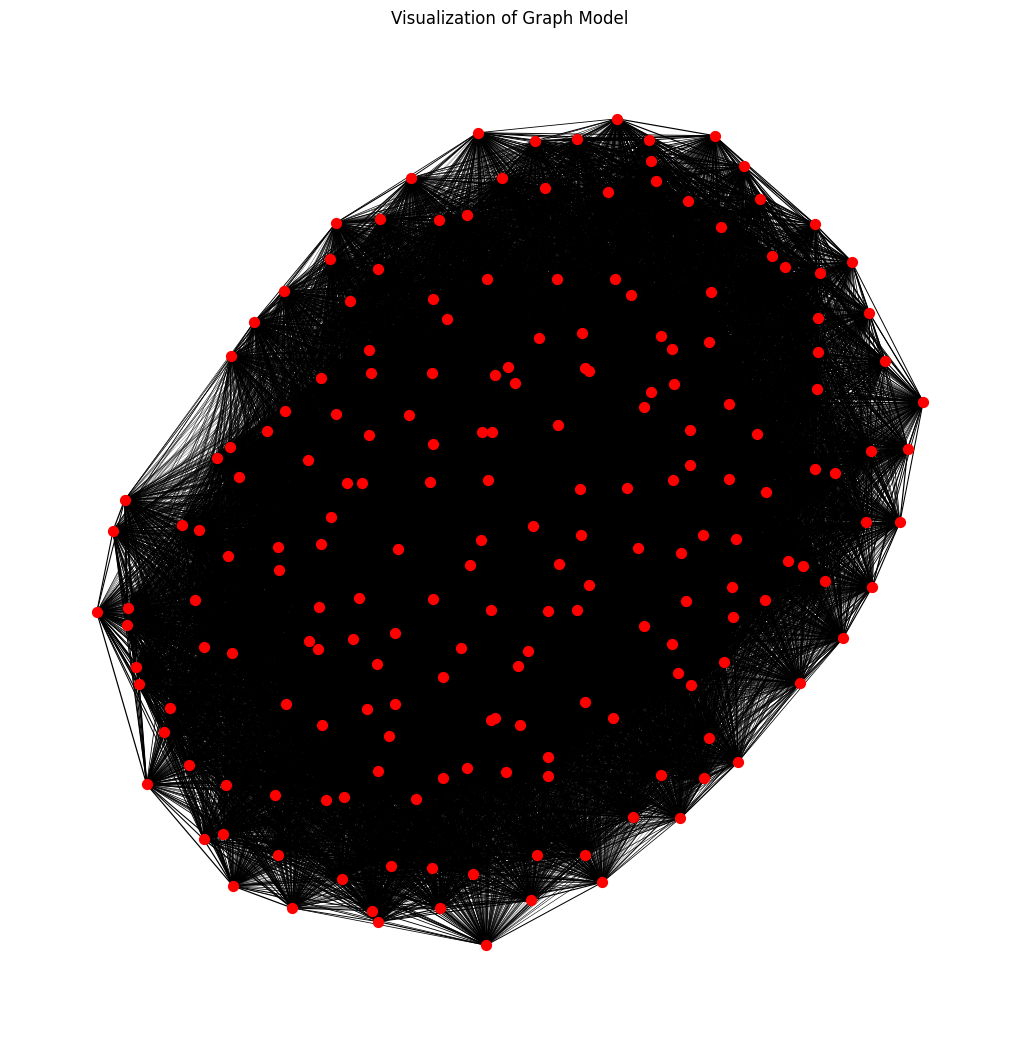

In [271]:
def plotGraph(G_full):
    pos = nx.spring_layout(G_full)

    edges = G_full.edges()
    weights = [G_full[u][v]['weight'] * 1 for u, v in edges] 

    plt.figure(figsize=(10, 10))
    nx.draw(
        G_full,
        pos,
        edge_color='black', 
        width=weights,     
        with_labels=False,  
        node_color='red',
        node_size=50
    )
    plt.title(f"Visualization of Graph Model")
    plt.show()

G_full = nx.from_numpy_array(similar_matrix_X)

GraphModel = plotGraph(G_full)

####  how can we simplify this graph?

### theshold method

+ связность графа не сохраняется, нужен иной метод

In [272]:
def theshold_method(similar_matrix, tau_in=0.8):
    tau = tau_in

    A = similar_matrix.copy()
    A[A < tau] = 0

    G_A = nx.from_numpy_array(A)


    GraphModel = plotGraph(G_A)

    return GraphModel

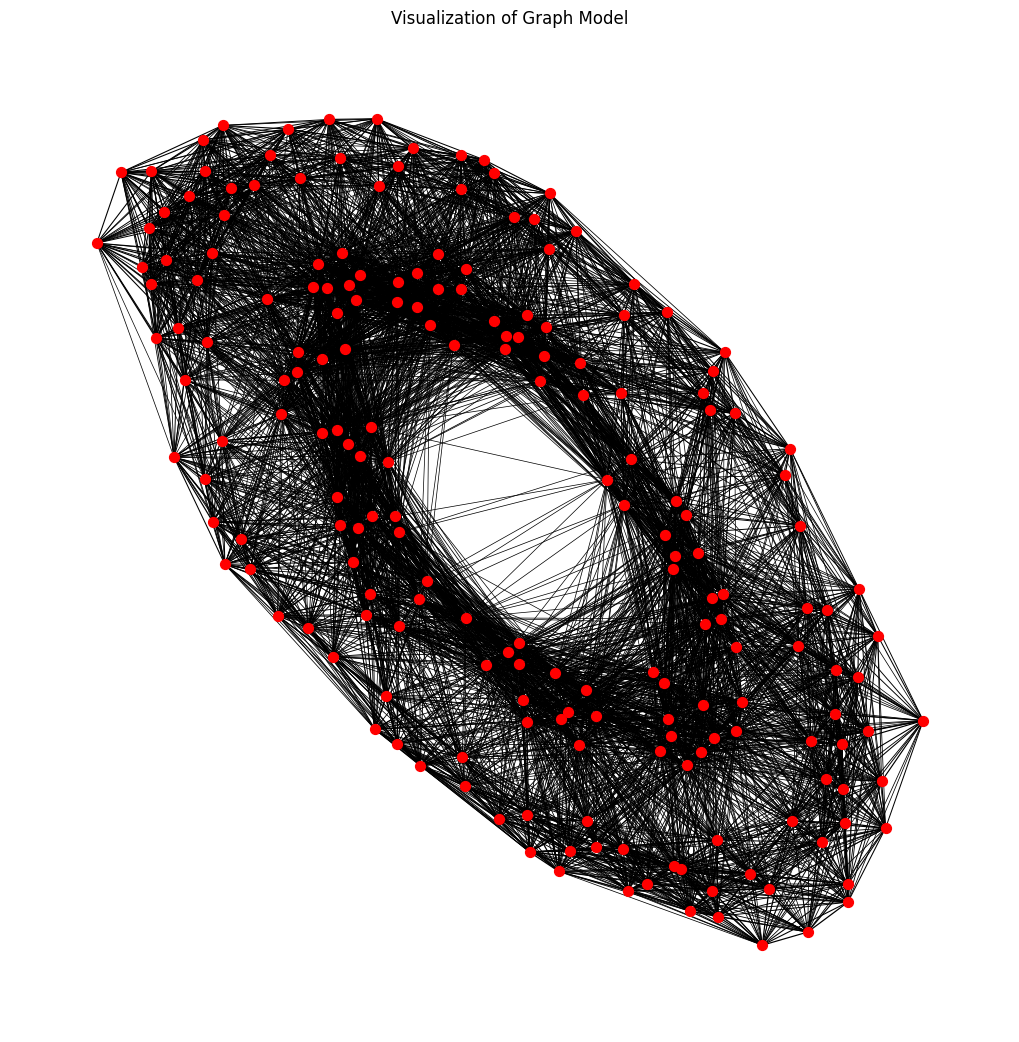

In [273]:
Thes_GM = theshold_method(similar_matrix_X, 0.5)

### MST method

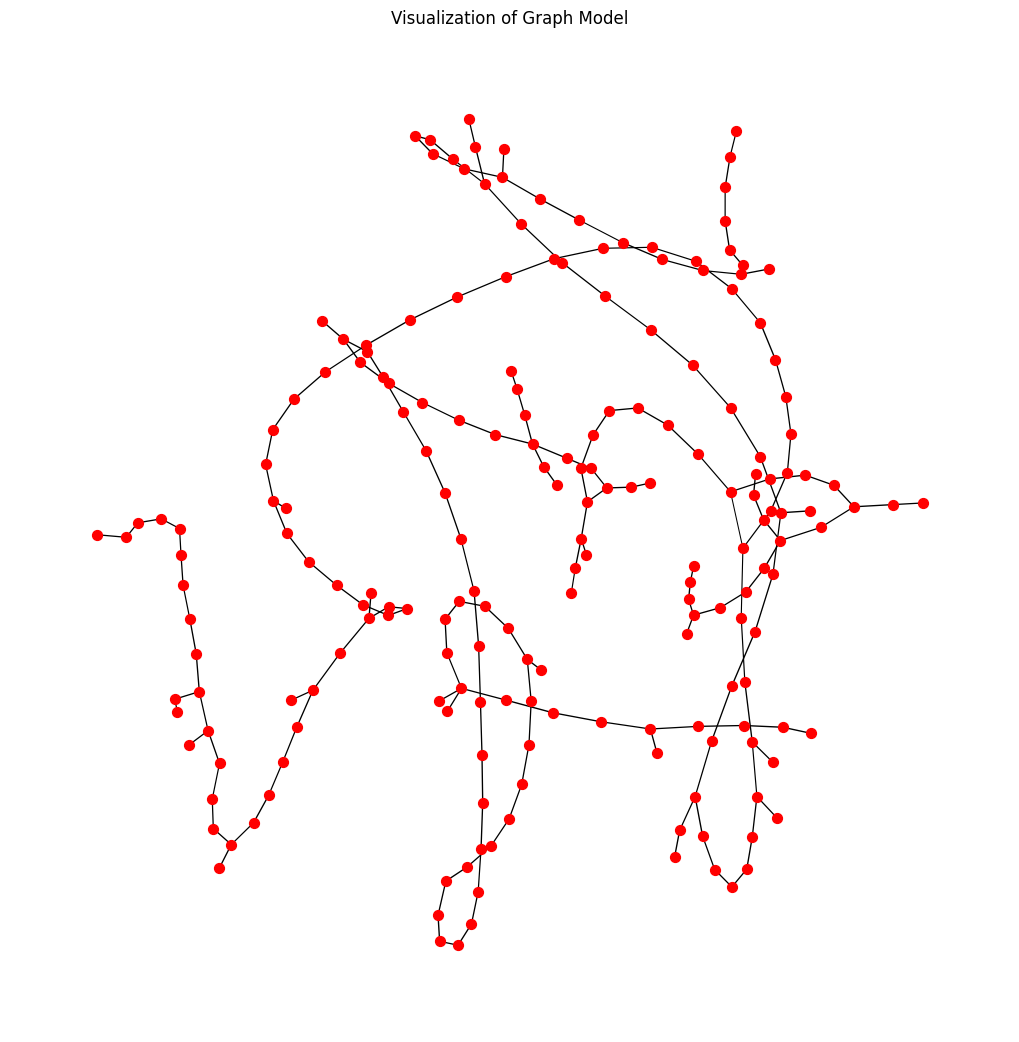

Graph with 199 nodes and 198 edges


In [274]:
def MST_method(similar_matrix):
    mst = nx.maximum_spanning_tree(nx.from_numpy_array(similar_matrix))
    plotGraph(mst)

    return mst

MST_G = MST_method(similar_matrix_X)
print(MST_G)

### PCA for visualization

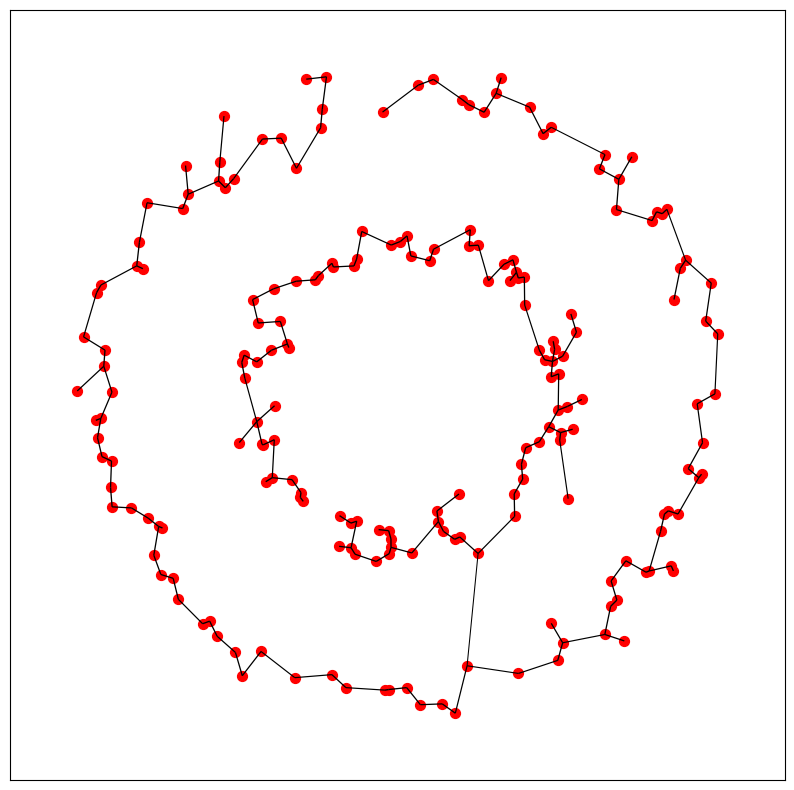

In [275]:
def PCA_(data, G_mast, clusters = None):
    data_scaled = StandardScaler().fit_transform(data)

    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data_scaled)
    pca_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])

    pos_pca = {i: principal_components[i, :] for i in range(len(pca_df))}

    plt.figure(figsize=(10, 10))
    plt.scatter(pca_df['PC1'], pca_df['PC2'], c = clusters, s=50) # Точки

    edges_mast = G_mast.edges(data=True)
    weights_mast = [d['weight'] * 1 for u, v, d in edges_mast] # Используем те же веса для рёбер

    nx.draw_networkx_edges(
        G_mast,
        pos=pos_pca, 
        edge_color='black',
        width=weights_mast,
        alpha=1,
    )
    
    plt.show()


PCA_(setX, MST_G, clusters='red')

## Пункт 1 для Y Dataset

In [276]:
dist_matirx_Y, dist_matrix_Y_condenced = getDistMatrix(setY)

In [277]:
similar_matrix_Y = getSimilarityMatrix(dist_matirx_Y)

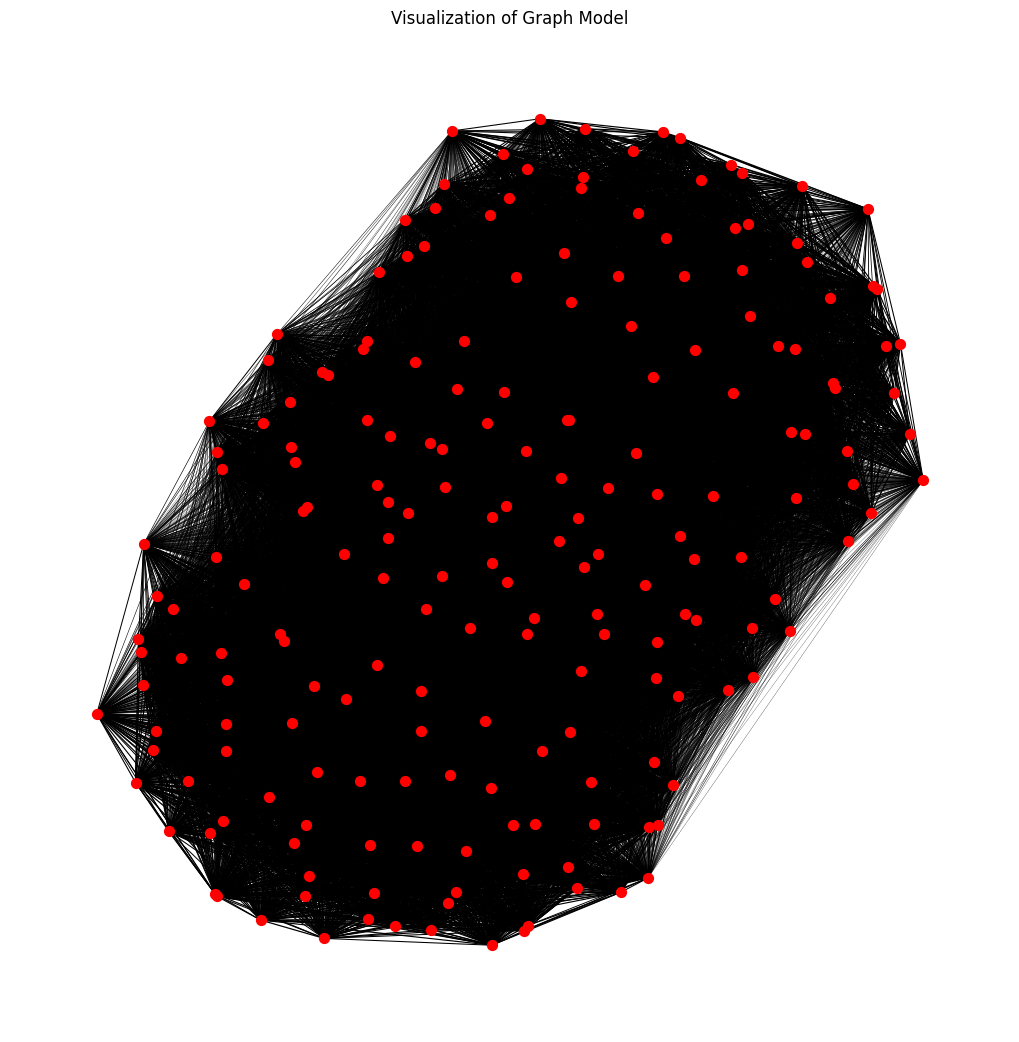

In [278]:
G_full_Y = nx.from_numpy_array(similar_matrix_Y)

GraphModel_Y = plotGraph(G_full_Y)

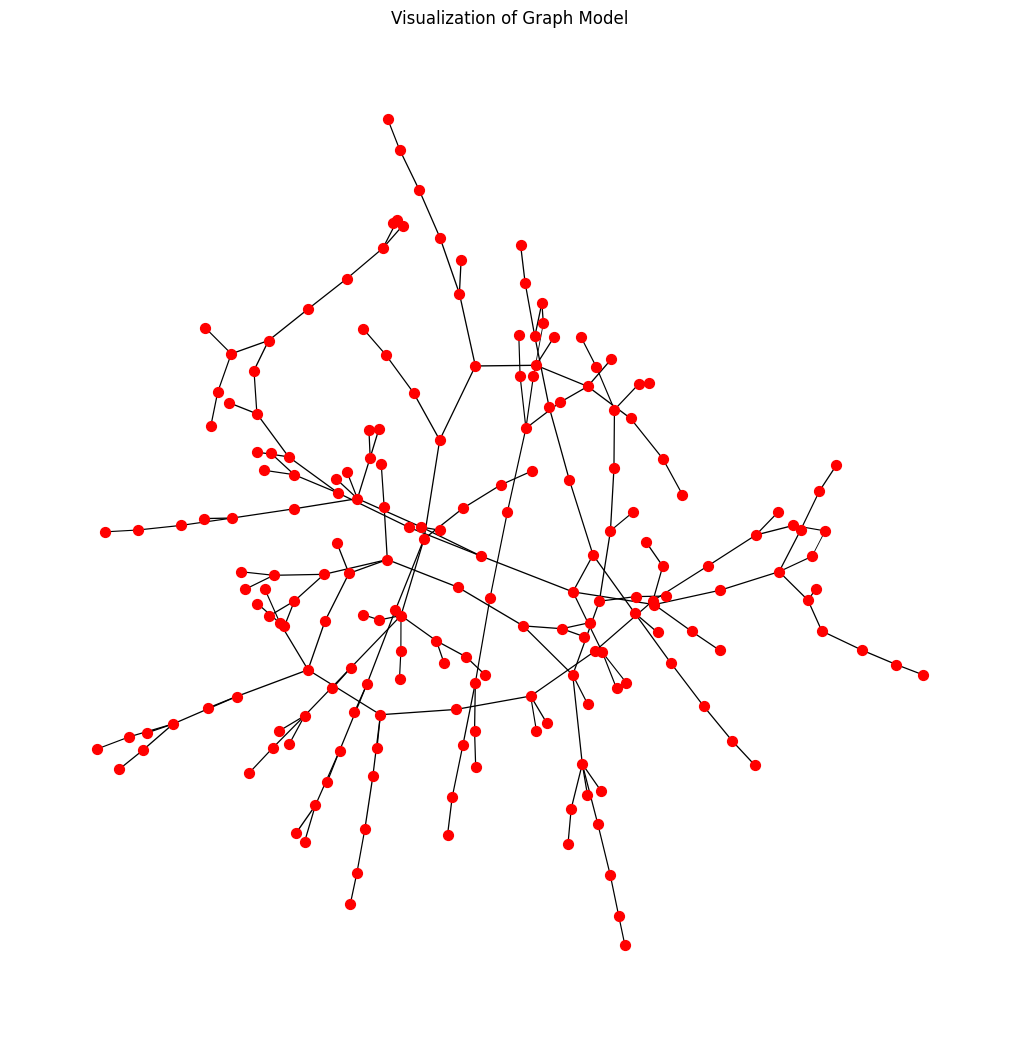

Graph with 199 nodes and 198 edges


In [279]:
MST_G_Y = MST_method(similar_matrix_Y)
print(MST_G_Y)

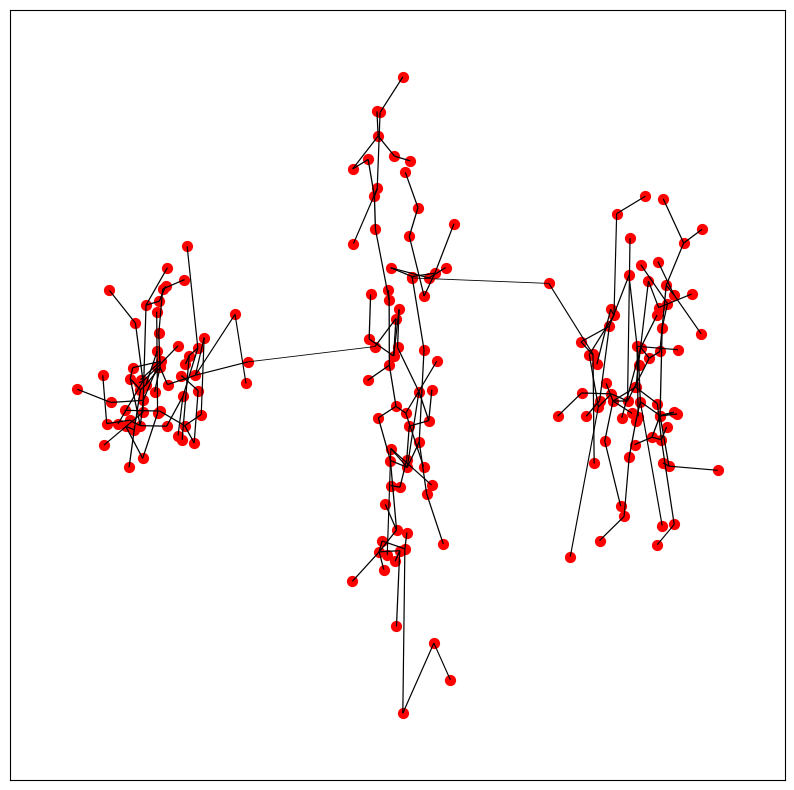

In [280]:
PCA_(setY, MST_G_Y, clusters='red')

## Пункт 2 для X Dataset

+ используем ward linkage

In [281]:
Z_X = linkage(dist_matrix_X_condenced, method='ward')

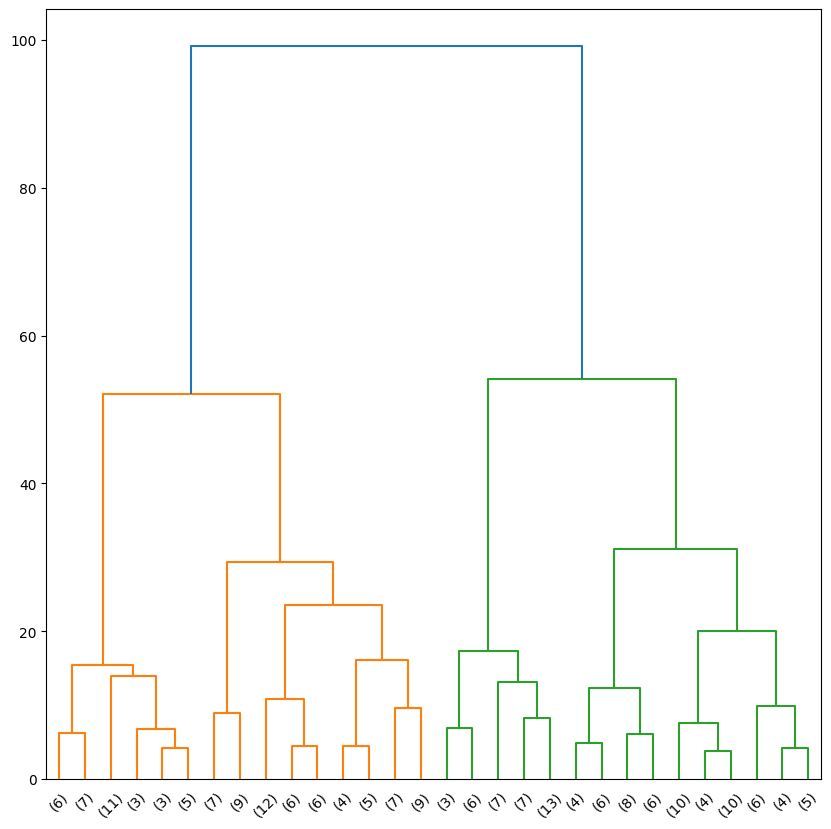

In [282]:
# dendogram
plt.figure(figsize=(10, 10))

dn = dendrogram(
    Z_X,
    truncate_mode='lastp',
    p=30,
    show_leaf_counts=True
)

plt.show()

In [283]:
cluster_labels_X_ward = fcluster(Z_X, t=60, criterion='distance')

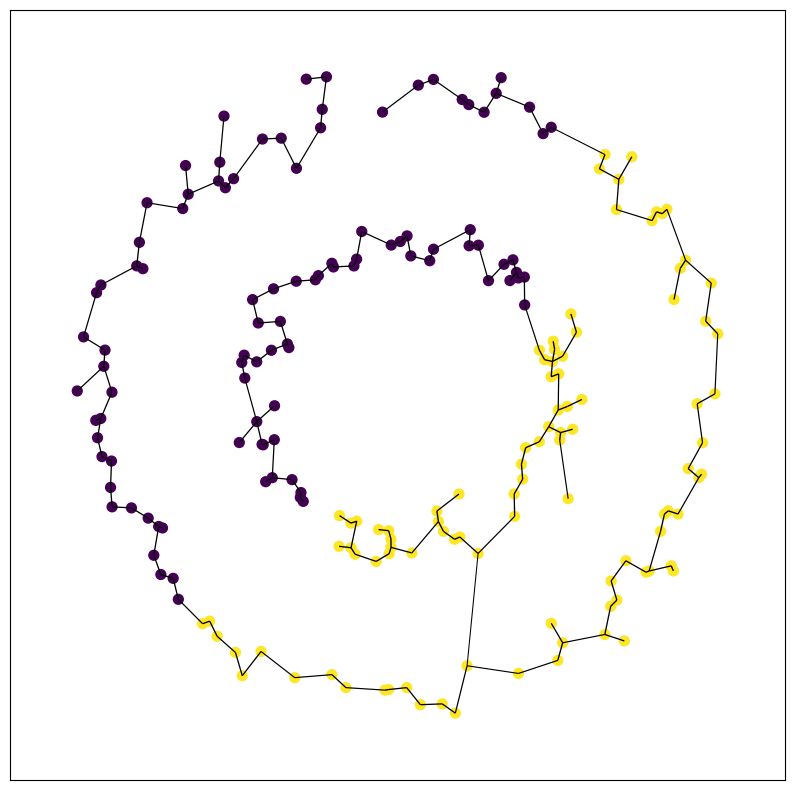

In [284]:
PCA_(setX, MST_G, cluster_labels_X_ward)

### k-means


In [285]:
k_means = KMeans(n_clusters=2, random_state=42, n_init='auto')

In [286]:
data_scaled_X = StandardScaler().fit_transform(setX)

In [287]:
cluster_labels_X_kmeans = k_means.fit_predict(data_scaled_X)

In [288]:
print(cluster_labels_X_kmeans)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


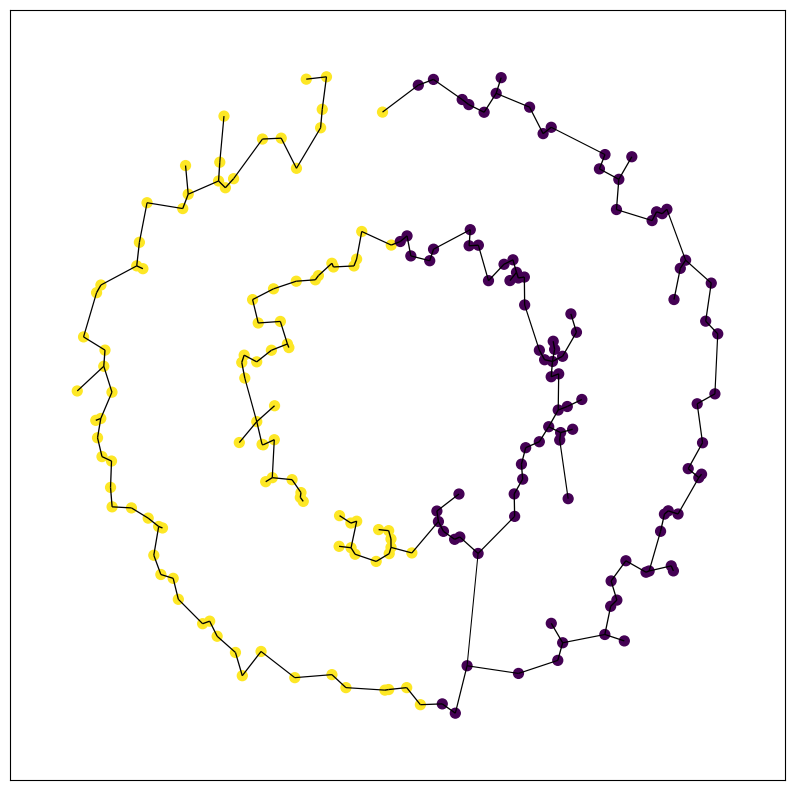

In [289]:
PCA_(setX, MST_G, cluster_labels_X_kmeans)

#### EM algorithm

In [290]:
gauss_mix = GaussianMixture(n_components=2, random_state=42, n_init=10)

In [291]:
cluster_labels_X_EM = gauss_mix.fit_predict(data_scaled_X)

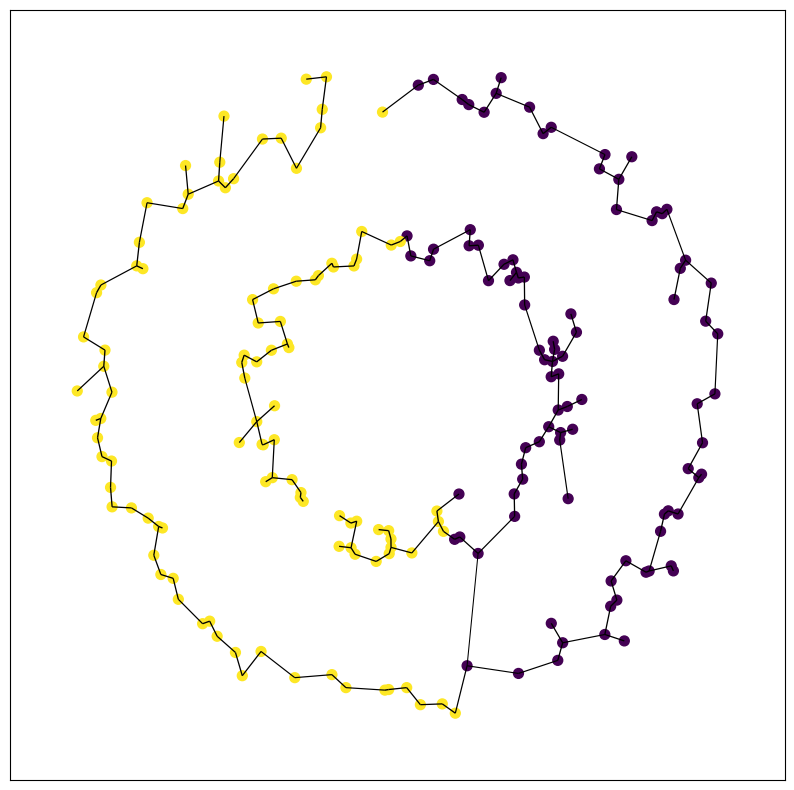

In [292]:
PCA_(setX, MST_G, cluster_labels_X_EM)

#### spectral algorithm

In [293]:
spectral_clus = SpectralClustering(affinity='precomputed', n_clusters=2, random_state=42)

In [294]:
cluster_labels_X_spectral = spectral_clus.fit_predict(similar_matrix_X)

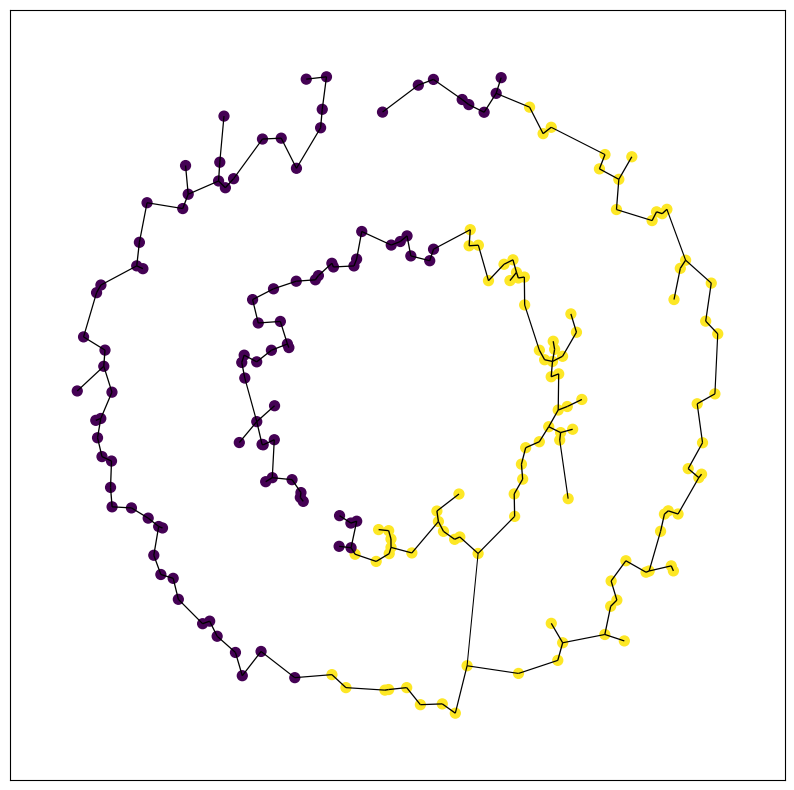

In [295]:
PCA_(setX, MST_G, cluster_labels_X_spectral)

#### comparison clusters with RAND index

In [296]:
CLUSTERS_X = [cluster_labels_X_ward, cluster_labels_X_kmeans, cluster_labels_X_EM, cluster_labels_X_spectral]

def RAND_index(cluster1, cluster2):
    return f"RAND index = {adjusted_rand_score(cluster1, cluster2)}"


### ward & k-means

In [297]:
RAND_index(CLUSTERS_X[0], CLUSTERS_X[1])

'RAND index = 0.2239791857973676'

### ward & EM

In [298]:
RAND_index(CLUSTERS_X[0], CLUSTERS_X[2])

'RAND index = 0.18704323241722196'

### ward & spectral

In [299]:
RAND_index(CLUSTERS_X[0], CLUSTERS_X[3])

'RAND index = 0.5433623677559761'

### k-means & EM

In [300]:
RAND_index(CLUSTERS_X[1], CLUSTERS_X[2])

'RAND index = 0.8824420658265663'

### k-means & spectral

In [301]:
RAND_index(CLUSTERS_X[1], CLUSTERS_X[3])

'RAND index = 0.5433623677559761'

### EM & spectral

In [302]:
RAND_index(CLUSTERS_X[2], CLUSTERS_X[3])

'RAND index = 0.48530342476523775'

### conclusions

EM & k-means - хорошо согласуются.

Из полученных значений RAND index можем заметить, что:
- Лишь k-means & EM алгоритмы разделили X датасет на схожие структурные кластеры => можем использовать лишь один из них при необходимости

- Сравнение же остальных методов показало, что каждый алгоритм (кроме указанных в предыдущем пункте) находит свои подструктуры данных, и как следствие заменить один алгоритм из пары другим не получится.


### Modular func

In [303]:
cluster_labels_X_ward_new = [1 if label == 2 else 0 for label in cluster_labels_X_ward.copy()]

FOR_MODULAR = [cluster_labels_X_ward_new, cluster_labels_X_kmeans, cluster_labels_X_EM, cluster_labels_X_spectral]

In [304]:
def Modular_for_clust(cluster):
    nodes_cluster1 = [i for i, label in enumerate(cluster) if label == 0]
    nodes_cluster2 = [i for i, label in enumerate(cluster) if label == 1]

    partition = [
        nodes_cluster1,
        nodes_cluster2
    ]

    Q = nx.community.modularity(MST_G, partition)

    return Q

In [305]:
for cluster in FOR_MODULAR:
    print(Modular_for_clust(cluster))

0.48626512544317724
0.48019702068744763
0.47335868544952486
0.48022578432290886


### Выводы:
Алгоритмы хорошо определили ествественные кластеры в данных

Высокие показатели функции модулярности говорят о том, что при кластеризации были найдены естественные сообщества в данных - Кластеры являются плотно связанными сообществами, где связи внутри групп значительно превосходят случайные ожидания.


### Общие выводы для кластера при k = 2 (X Dataset): 
- Несмотря на то, что все алгоритмы демонстрируют высокую модулярность (что свидетельствует о наличии естественной кластерной структуры в данных), попарное сравнение с помощью Rand Index показывает, что они выделяют различные группировки объектов. Это указывает на то, что данные допускают несколько равноправных способов разделения, каждый из которых имеет внутреннюю связность

- Высокие значения фукнции модклярности, и то, что для каждого из алгоритмов они получились примерно равными позволяет нам говорить о том, что количество кластеров = 2 является наиболее выраженным уровнем сообществ в данных (наиболее доминирующий уровень иерархий в данных)


## Пункт 2 для Y Dataset


In [306]:
Z_Y = linkage(dist_matrix_Y_condenced, method='ward')

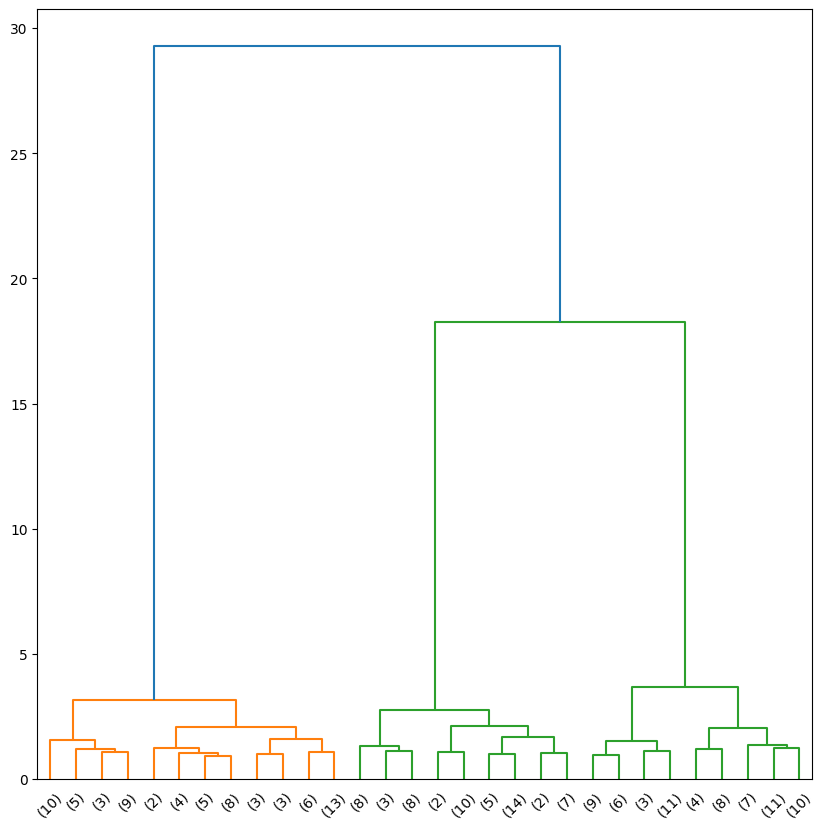

In [307]:
# dendogram
plt.figure(figsize=(10, 10))

dn = dendrogram(
    Z_Y,
    truncate_mode='lastp',
    p=30,
    show_leaf_counts=True
)

plt.show()

In [308]:
cluster_labels_Y_ward = fcluster(Z_Y, t=25, criterion='distance')

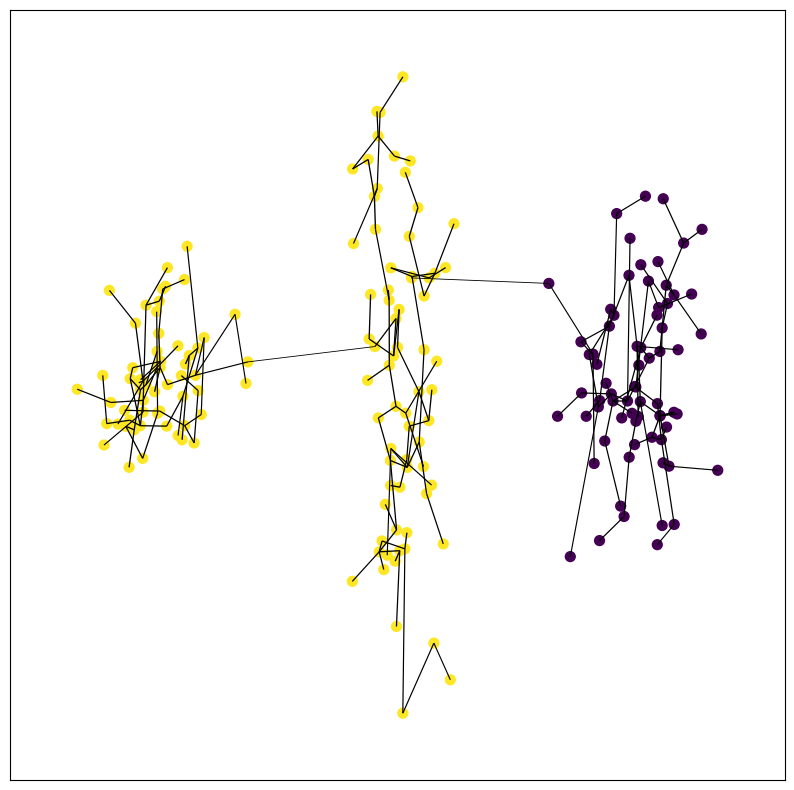

In [309]:
PCA_(setY, MST_G_Y, cluster_labels_Y_ward)

### k-means

In [310]:
data_scaled_Y = StandardScaler().fit_transform(setY)

In [311]:
cluster_labels_Y_kmeans = k_means.fit_predict(data_scaled_Y)

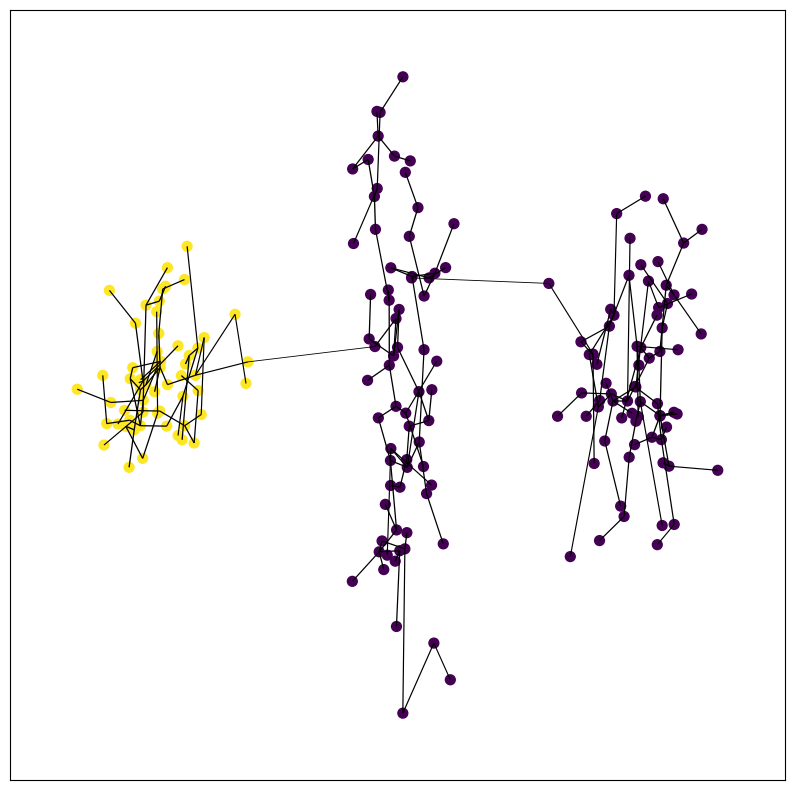

In [312]:
PCA_(setY, MST_G_Y, cluster_labels_Y_kmeans)

### EM

In [313]:
cluster_labels_Y_EM = gauss_mix.fit_predict(data_scaled_Y)

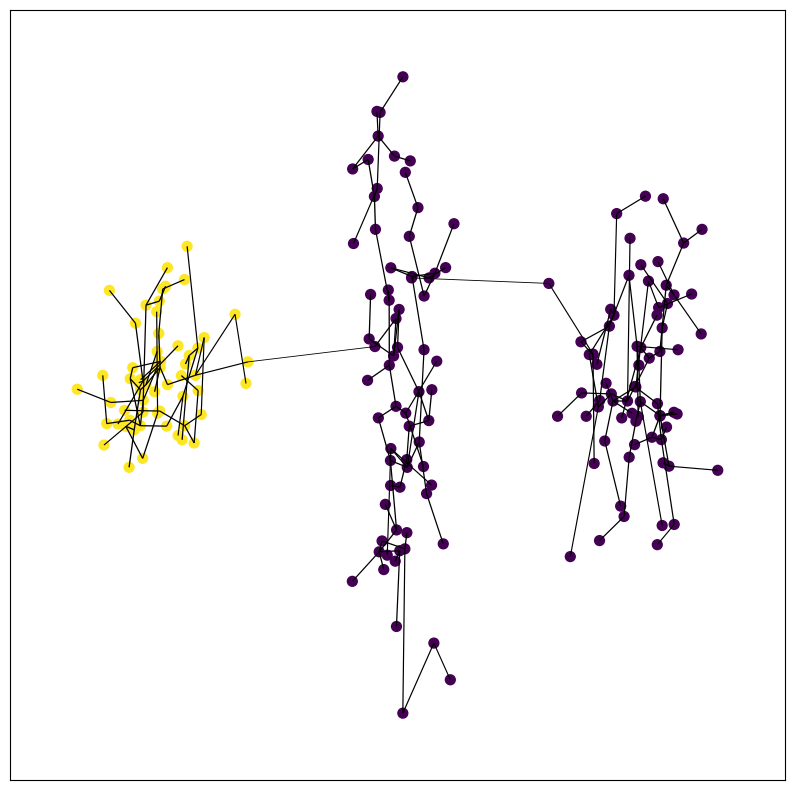

In [314]:
PCA_(setY, MST_G_Y, cluster_labels_Y_EM)

### spectral 

In [315]:
cluster_labels_Y_spectral = spectral_clus.fit_predict(similar_matrix_Y)

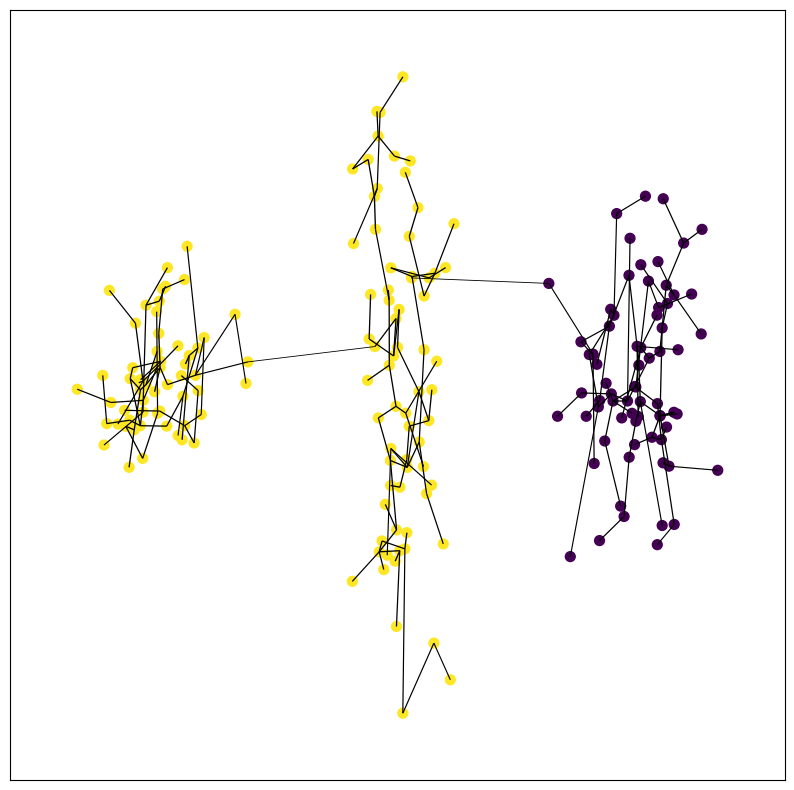

In [316]:
PCA_(setY, MST_G_Y, cluster_labels_Y_spectral)

### RAND index Y

In [317]:
FOR_RAND_Y = [cluster_labels_Y_ward, cluster_labels_Y_kmeans, cluster_labels_Y_EM, cluster_labels_Y_spectral]

#### ward & k-means

In [318]:
RAND_index(FOR_RAND_Y[0], FOR_RAND_Y[1])

'RAND index = 0.0778609957374689'

#### ward & EM

In [319]:
RAND_index(FOR_RAND_Y[0], FOR_RAND_Y[2])

'RAND index = 0.0778609957374689'

#### ward & spectral

In [320]:
RAND_index(FOR_RAND_Y[0], FOR_RAND_Y[3])

'RAND index = 1.0'

#### k-means & EM

In [321]:
RAND_index(FOR_RAND_Y[1], FOR_RAND_Y[2])

'RAND index = 1.0'

#### k-means & spectral

In [322]:
RAND_index(FOR_RAND_Y[1], FOR_RAND_Y[3])

'RAND index = 0.0778609957374689'

#### EM & spectral

In [323]:
RAND_index(FOR_RAND_Y[2], FOR_RAND_Y[3])

'RAND index = 0.0778609957374689'

Выводы: 

singularity function for Y

In [324]:
cluster_labels_Y_ward_new = [1 if label == 2 else 0 for label in cluster_labels_Y_ward.copy()]

FOR_MODULAR_Y = [cluster_labels_Y_ward_new, cluster_labels_Y_kmeans, cluster_labels_Y_EM, cluster_labels_Y_spectral]

In [325]:
for cluster in FOR_MODULAR_Y:
    print(Modular_for_clust(cluster))

0.019334409140586123
-0.0012503688270574104
-0.0012503688270574104
0.019334409140586123


Общие выводы 2-cluster Y

## Пункт 3 для X Dataset

In [326]:
cluster_labels_X_ward_3 = fcluster(
    Z_X,
    t=3,
    criterion='maxclust'
)

Из ранее построенной иерархической кластеризации (Ward linkage) извлекаем разбиение данных на 3 кластера. Метод использует матрицу расстояний и формирует компактные кластеры за счёт минимизации внутрикластерной дисперсии.

### k-means (k = 3)


In [327]:
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init='auto')
cluster_labels_X_kmeans_3 = kmeans_3.fit_predict(data_scaled_X)

Алгоритм k-means применяется к стандартизированным данным и разбивает объекты на 3 кластера, минимизируя сумму квадратов расстояний до центров кластеров.

In [328]:
gmm_3 = GaussianMixture(n_components=3, random_state=42, n_init=10)
cluster_labels_X_EM_3 = gmm_3.fit_predict(data_scaled_X)

Аппроксимируем данные смесью трёх нормальных распределений. Каждому объекту присваивается кластер с максимальной апостериорной вероятностью принадлежности.

In [329]:
spectral_3 = SpectralClustering(
    n_clusters=3,
    affinity='precomputed',
    random_state=42
)

cluster_labels_X_spectral_3 = spectral_3.fit_predict(similar_matrix_X)

Спектральная кластеризация выполняется на основе матрицы сходства, построенной из графовой модели данных. Метод учитывает структуру связей между объектами

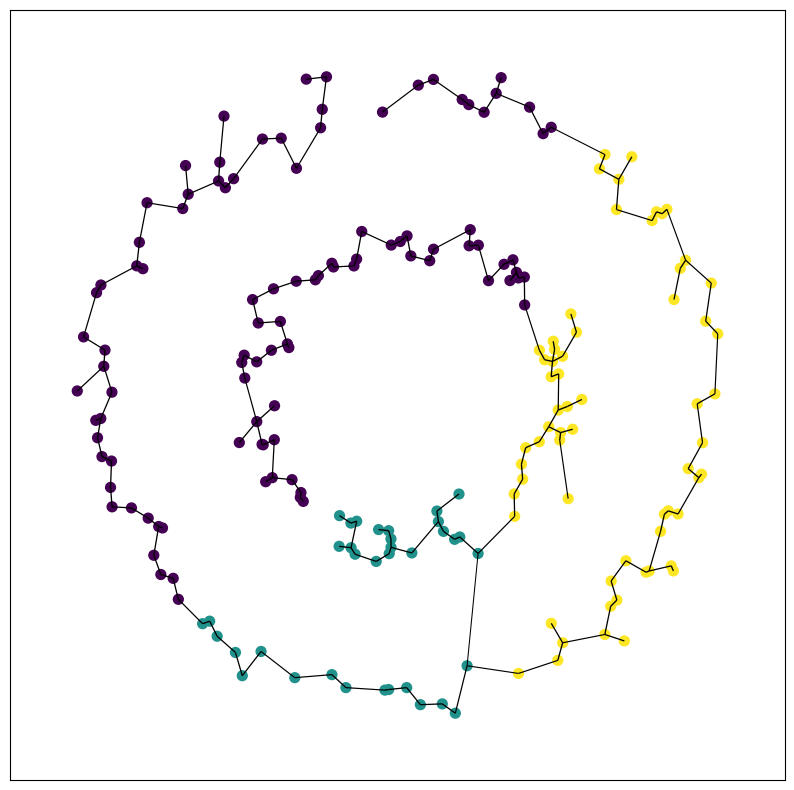

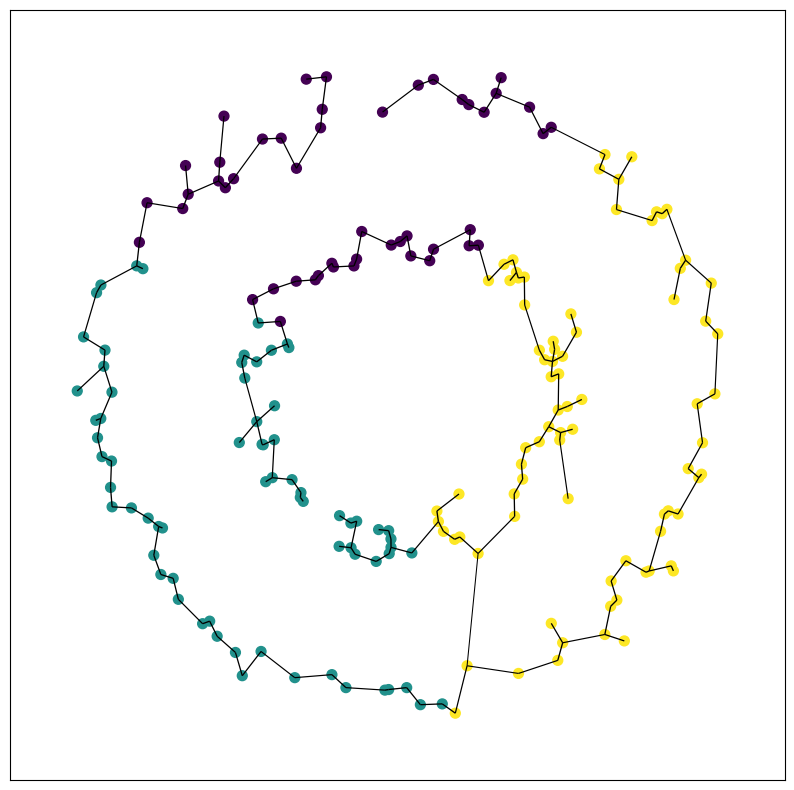

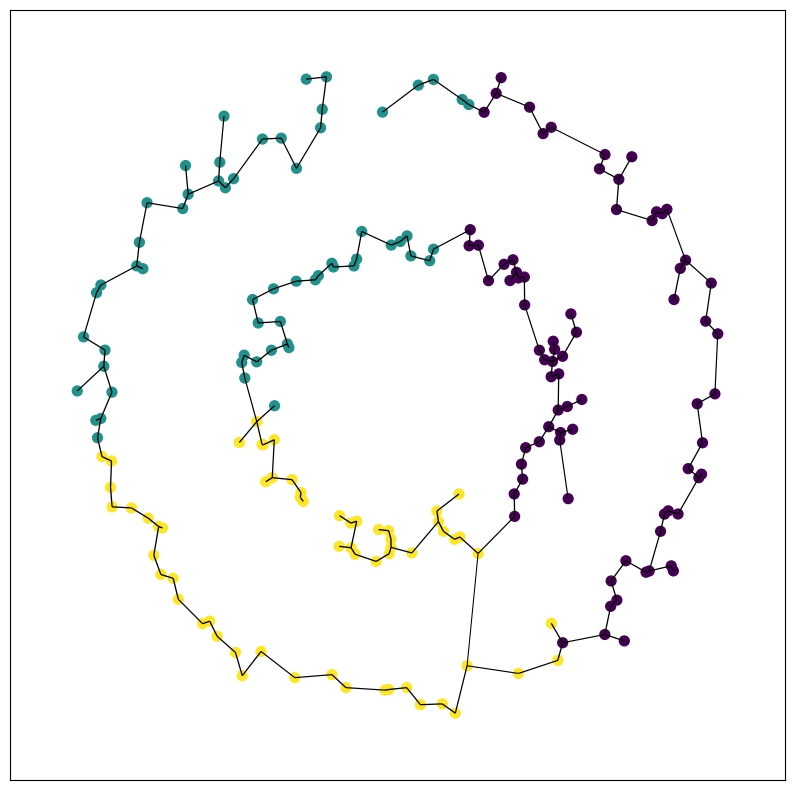

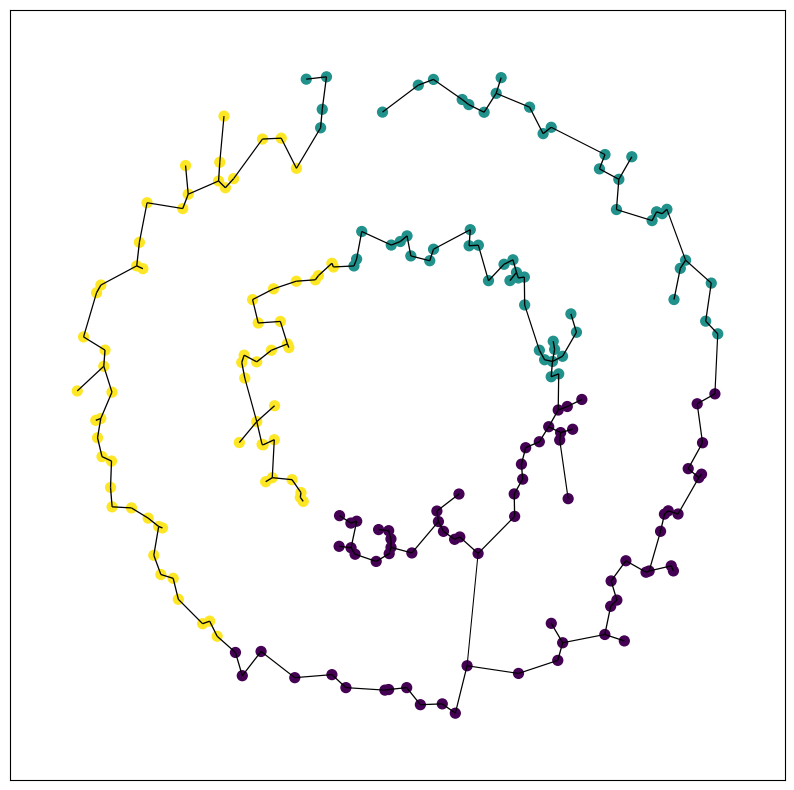

In [330]:
PCA_(setX, MST_G, cluster_labels_X_ward_3)
PCA_(setX, MST_G, cluster_labels_X_kmeans_3)
PCA_(setX, MST_G, cluster_labels_X_EM_3)
PCA_(setX, MST_G, cluster_labels_X_spectral_3)

Здесь мы визуализировали наши кластеры.

Сравнение кластеризаций (RAND index)

In [331]:
CLUSTERS_X_3 = [
    cluster_labels_X_ward_3,
    cluster_labels_X_kmeans_3,
    cluster_labels_X_EM_3,
    cluster_labels_X_spectral_3
]

names = ['Ward_X', 'KMeans_X', 'EM_X', 'Spectral_X']

Все полученные разбиения на 3 кластера объединяем в список для последующего сравнения и анализа качества кластеризации.

In [332]:
for i in range(len(CLUSTERS_X_3)):
    for j in range(i+1, len(CLUSTERS_X_3)):
        print(
            names[i], '&', names[j],
            RAND_index(CLUSTERS_X_3[i], CLUSTERS_X_3[j])
        )

Ward_X & KMeans_X RAND index = 0.4059036035541794
Ward_X & EM_X RAND index = 0.4499436224910902
Ward_X & Spectral_X RAND index = 0.3772878245806738
KMeans_X & EM_X RAND index = 0.5189626486837193
KMeans_X & Spectral_X RAND index = 0.29067749805281434
EM_X & Spectral_X RAND index = 0.2835433981625041


Для каждой пары кластеризаций вычисляется Adjusted RAND Index, характеризующий степень совпадения разбиений.

### Сделаем выводы для этих сравнений: 

Ward & KMeans

RAND ≈ 0.41

Разбиения имеют умеренное совпадение.
Это означает, что часть объектов Ward и k-means относят к одинаковым кластерам, однако в целом структура кластеров заметно различается из-за различия используемых подходов (иерархический vs центроидный).

Ward & EM

RAND ≈ 0.45

Сходство немного выше, чем с k-means.
Вероятностная модель EM в ряде случаев ближе к структуре, выявляемой иерархической кластеризацией, но различия всё ещё существенны.

Ward & Spectral

RAND ≈ 0.38

Низко-средний уровень совпадения.
Spectral clustering использует графовую модель данных, тогда как Ward работает в пространстве расстояний, что приводит к различным разбиениям.

KMeans & EM

RAND ≈ 0.52 (наибольшее значение)

Наиболее близкие разбиения среди всех пар.
Оба метода работают в пространстве признаков и ориентированы на компактные кластеры, что объясняет их высокую согласованность.

KMeans & Spectral

RAND ≈ 0.29

Низкое совпадение разбиений.
k-means игнорирует графовую структуру данных, тогда как Spectral clustering опирается на неё, что приводит к существенно разным результатам.

EM & Spectral

RAND ≈ 0.28

Минимальное совпадение среди всех пар.
Методы используют принципиально разные модели данных (вероятностную и графовую), поэтому полученные кластеры существенно различаются.

### То есть, что мы имеем: 
- Наиболее согласованные разбиения дают k-means и EM

- Spectral clustering формирует разбиения, значительно отличающиеся от методов, работающих в пространстве признаков

- Ward занимает промежуточное положение, частично согласуясь с k-means и EM

- В целом, при k = 3 наблюдается низкая устойчивость разбиений, что указывает на неоднозначность структуры данных для такого числа кластеров

### Модулярность для k = 3

In [333]:
def modularity_for_3_clusters(cluster_labels, G):
    clusters = []
    for c in np.unique(cluster_labels):
        clusters.append([i for i, label in enumerate(cluster_labels) if label == c])

    return nx.community.modularity(G, clusters)


In [334]:
for name, cl in zip(names, CLUSTERS_X_3):
    print(name, modularity_for_3_clusters(cl, MST_G))

Ward_X 0.5937068334030926
KMeans_X 0.6118644227562136
EM_X 0.6217587223686878
Spectral_X 0.6404529567246587


Для каждого алгоритма кластеризации рассчитывается модулярность, позволяющая оценить согласованность разбиения со структурой графа MST.

Все методы дают достаточно высокие значения модулярности, что говорит о наличии кластерной структуры в данных. Spectral clustering лучше всего соответствует графовой структуре данных. EM и k-means занимают промежуточное положение. Ward наименее согласованна с графом среди рассмотренных методов.

Совместно с результатами RAND индекса это указывает на то, что при k = 3 структура кластеров сильно зависит от выбранного алгоритма, а графовые методы выявляют иную организацию данных, чем методы, работающие в пространстве признаков.

## Пункт 3 для Y Dataset

In [335]:
cluster_labels_Y_ward_3 = fcluster(
    Z_Y,
    t=3,
    criterion='maxclust'
)

k-means

In [336]:
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init='auto')
cluster_labels_Y_kmeans_3 = kmeans_3.fit_predict(data_scaled_Y)

EM

In [337]:
gmm_3 = GaussianMixture(n_components=3, random_state=42, n_init=10)
cluster_labels_Y_EM_3 = gmm_3.fit_predict(data_scaled_Y)

Spectral

In [338]:
spectral_3 = SpectralClustering(
    n_clusters=3,
    affinity='precomputed',
    random_state=42
)
cluster_labels_Y_spectral_3 = spectral_3.fit_predict(similar_matrix_Y)

### Визуализация PCA + MST

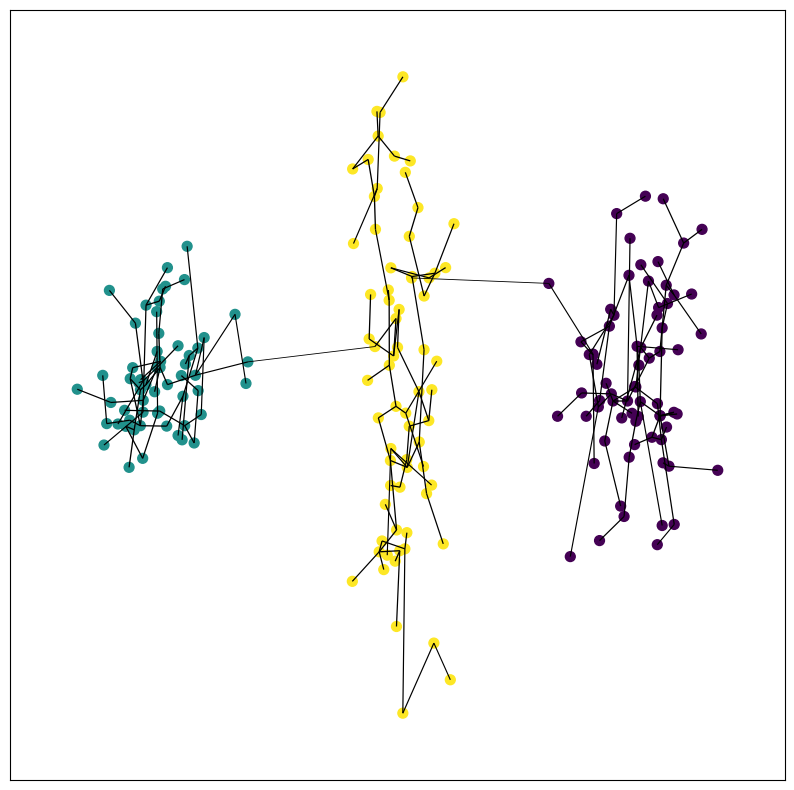

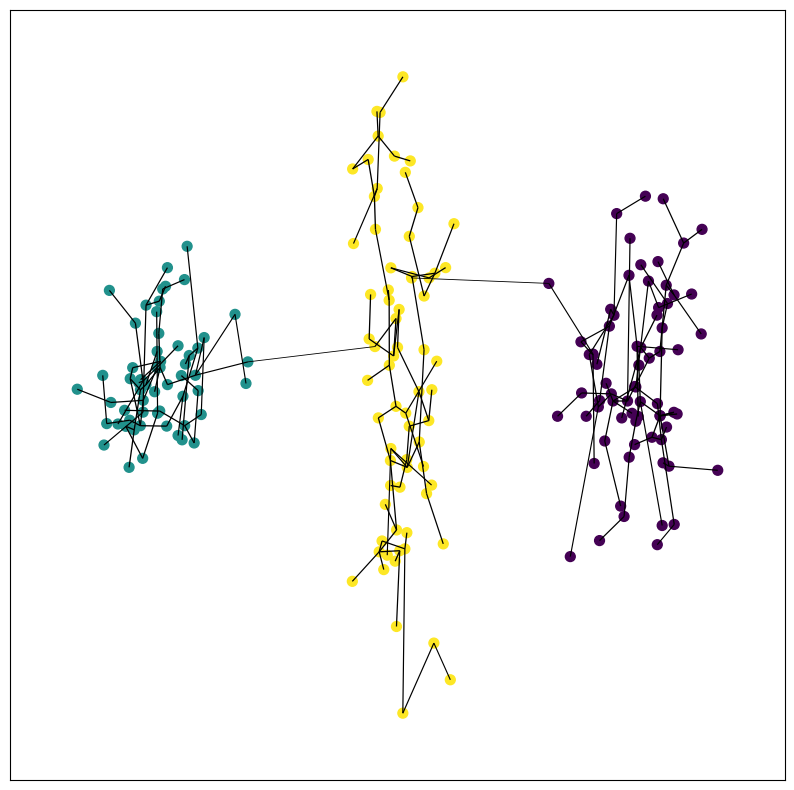

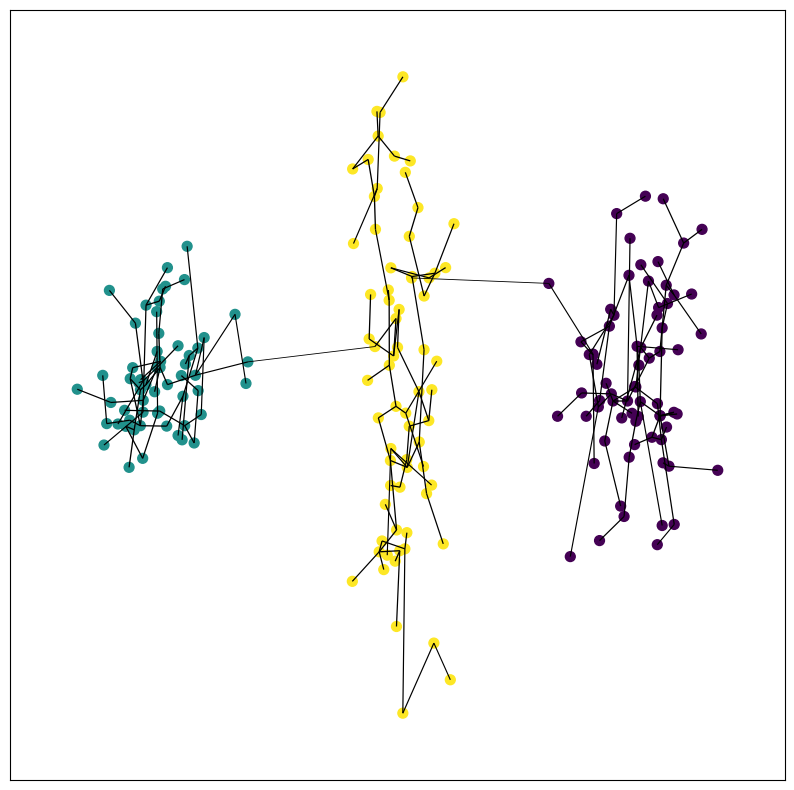

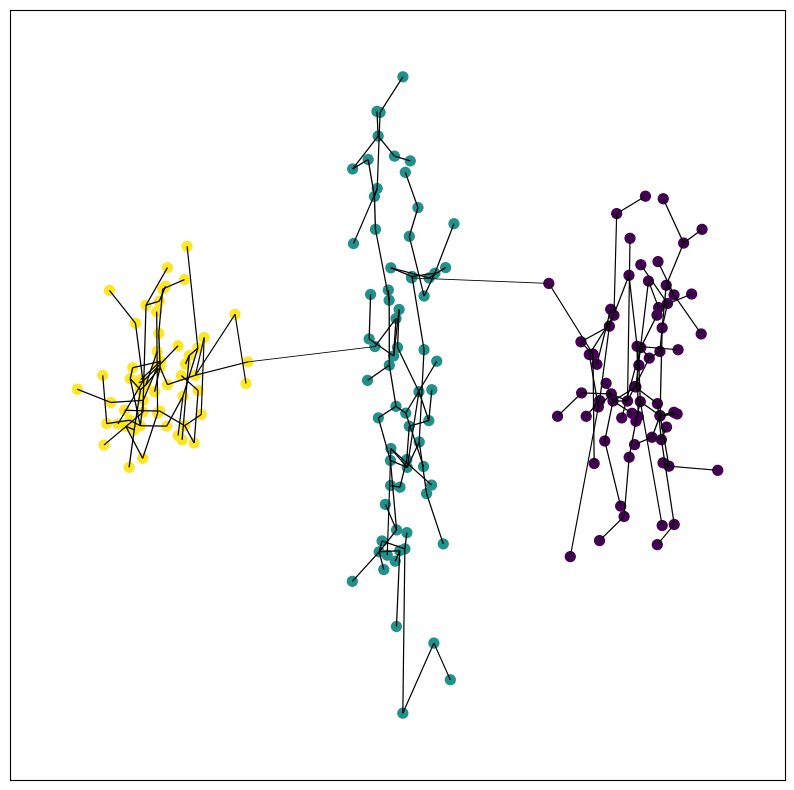

In [339]:
PCA_(setY, MST_G_Y, cluster_labels_Y_ward_3)
PCA_(setY, MST_G_Y, cluster_labels_Y_kmeans_3)
PCA_(setY, MST_G_Y, cluster_labels_Y_EM_3)
PCA_(setY, MST_G_Y, cluster_labels_Y_spectral_3)

Визуализации наших разбиений, полученных с помощью Ward, k-means, EM и Spectral clustering совпадают. Во всех случаях наблюдаются три чётко отделённых кластера с одинаковым расположением объектов и идентичной структурой рёбер максимального остовного дерева. То есть все алгоритмы выявляют одну и ту же кластерную структуру.

In [340]:
CLUSTERS_Y_3 = [
    cluster_labels_Y_ward_3,
    cluster_labels_Y_kmeans_3,
    cluster_labels_Y_EM_3,
    cluster_labels_Y_spectral_3
]
names = ['Ward_Y', 'KMeans_Y', 'EM_Y', 'Spectral_Y']

### RAND index

In [341]:
for i in range(len(CLUSTERS_Y_3)):
    for j in range(i+1, len(CLUSTERS_Y_3)):
        print(
            names[i], '&', names[j],
            RAND_index(CLUSTERS_Y_3[i], CLUSTERS_Y_3[j])
        )

Ward_Y & KMeans_Y RAND index = 1.0
Ward_Y & EM_Y RAND index = 1.0
Ward_Y & Spectral_Y RAND index = 1.0
KMeans_Y & EM_Y RAND index = 1.0
KMeans_Y & Spectral_Y RAND index = 1.0
EM_Y & Spectral_Y RAND index = 1.0


In [342]:
np.unique(cluster_labels_Y_ward_3, return_counts=True)
np.unique(cluster_labels_Y_kmeans_3, return_counts=True)
np.unique(cluster_labels_Y_EM_3, return_counts=True)
np.unique(cluster_labels_Y_spectral_3, return_counts=True)

(array([0, 1, 2], dtype=int32), array([71, 69, 59]))

Для набора данных Y все рассмотренные методы кластеризации при k = 3 дали полностью совпадающие разбиения, что подтверждается значением RAND индекса, равным 1. Это указывает на наличие чётко выраженной и устойчивой кластерной структуры в данных, которая одинаково выявляется различными алгоритмами, несмотря на различие используемых моделей.

В отличие от Dataset X, где наблюдалась зависимость результатов от метода кластеризации, набор Y демонстрирует более простую и однозначную структуру, что делает разбиение на 3 кластера устойчивым и интерпретируемым.

### Модулярность

In [343]:
for name, cl in zip(names, CLUSTERS_Y_3):
    print(name, modularity_for_3_clusters(cl, MST_G_Y))

Ward_Y 0.6576635058079665
KMeans_Y 0.6576635058079665
EM_Y 0.6576635058079665
Spectral_Y 0.6576635058079665


У нас вышло так, что значения модулярности для всех рассмотренных алгоритмов кластеризации совпадают и составляют 0.658. Это говорит о том, что все методы выявляют одну и ту же структуру сообществ в графовой модели данных. Полученное разбиение на 3 кластера хорошо согласуется со структурой графа и является устойчивым и однозначным для набора данных Y.

## Общий случай для X Dataset

Определение числа кластеров
Метод «локтя» (Elbow method)

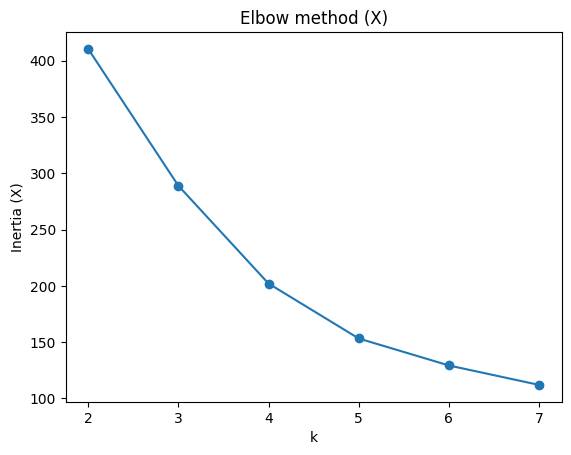

In [344]:
inertia_X = []
K = range(2, 8)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(data_scaled_X)
    inertia_X.append(km.inertia_)

plt.plot(K, inertia_X, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia (X)")
plt.title("Elbow method (X)")
plt.show()

Вычисляется внутрикластерная сумма квадратов расстояний для разных значений числа кластеров с целью выявления оптимального k. По форме графика мы можем определить точку излома, соответствующую разумному числу кластеров в данных.

На графике мы показываем зависимость inertia (суммы внутрикластерных квадратов расстояний) от числа кластеров k.

- При увеличении k значение inertia монотонно уменьшается, так как кластеры становятся меньше.

- Наиболее резкое уменьшение inertia наблюдаем при переходе от k = 2 к k = 3 и от k = 3 к k = 4.

- Начиная с k = 4, снижение inertia замедляется и кривая становится более пологой.

Точка излома (локоть) графика находится в области k = 3–4.
Это означает, что дальнейшее увеличение числа кластеров даёт лишь незначительное улучшение качества кластеризации.

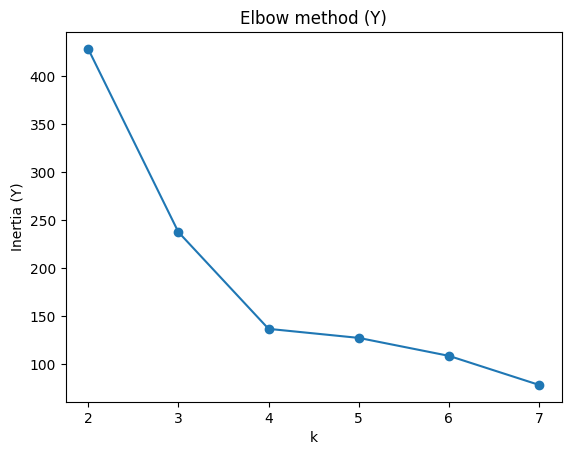

In [345]:
inertia_Y = []
K = range(2, 8)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(data_scaled_Y)
    inertia_Y.append(km.inertia_)

plt.plot(K, inertia_Y, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia (Y)")
plt.title("Elbow method (Y)")
plt.show()

## Общий случай для Y Dataset

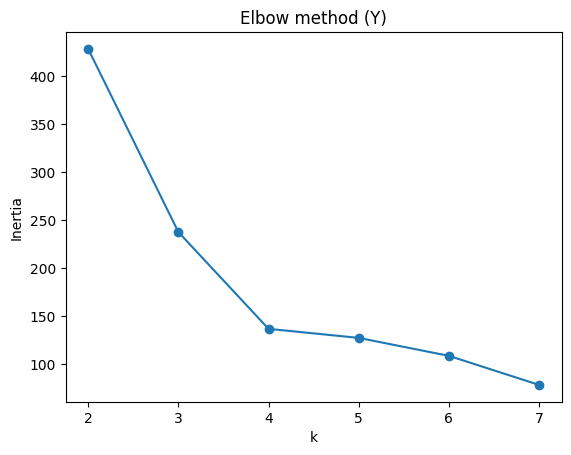

In [346]:
inertia_Y = []
K = range(2, 8)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(data_scaled_Y)
    inertia_Y.append(km.inertia_)

plt.plot(K, inertia_Y, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow method (Y)")
plt.show()

По графику видим наибольшее снижение значения inertia наблюдается при переходе от k = 2 к k = 3, после чего уменьшение становится менее выраженным. Это указывает на то, что разбиение на 3 кластера является обоснованным для набора данных Y.

## Попробуем альтернативный метод: Silhouette score, для X&Y Datasets

Silhouette score оценивает компактность кластеров и их отделимость друг от друга, позволяя сравнить качество кластеризации при разных k.

Silhouette score характеризует качество кластеризации, учитывая одновременно компактность кластеров и отделимость кластеров друг от друга.

Значения лежат в диапазоне от −1 до 1, и чем больше значение, тем лучше качество кластеризации.

In [347]:
from sklearn.metrics import silhouette_score

for k in range(2, 6):
    labels = KMeans(n_clusters=k, random_state=42, n_init='auto').fit_predict(data_scaled_X)
    print(k, silhouette_score(data_scaled_X, labels))

2 0.42213388946044406
3 0.38978003486709556
4 0.3858792498306555
5 0.3793526217551415


Максимальное значение silhouette score достигается при k = 2. При увеличении числа кластеров значение показателя монотонно уменьшается, что свидетельствует о снижении компактности кластеров и их отделимости друг от друга. Следовательно, для набора данных X наиболее качественным является разбиение на 2 кластера

In [348]:
for k in range(2, 6):
    labels = KMeans(n_clusters=k, random_state=42, n_init='auto').fit_predict(data_scaled_Y)
    print(k, silhouette_score(data_scaled_Y, labels))

2 0.45677742854869186
3 0.5350395937954092
4 0.5718383228244376
5 0.46026251726606443


Наибольшее значение silhouette score достигается при k = 4. При переходе от k = 2 к k = 4 качество кластеризации увеличивается, что указывает на более детализированную и хорошо отделимую структуру данных Y. При дальнейшем увеличении числа кластеров (k = 5) качество кластеризации снижается.

In [349]:
sil_kmeans_2 = silhouette_score(data_scaled_X, cluster_labels_X_kmeans)
sil_kmeans_3 = silhouette_score(data_scaled_X, cluster_labels_X_kmeans_3)

print("Silhouette X k=2:", sil_kmeans_2)
print("Silhouette X k=3:", sil_kmeans_3)

Silhouette X k=2: 0.42213388946044406
Silhouette X k=3: 0.38978003486709556


Значение silhouette score для X Dataset при k = 2 выше, чем при k = 3, что указывает на более компактные и лучше отделённые кластеры при разбиении на 2 кластера. Следовательно, с точки зрения silhouette score, разбиение X Dataset на 2 кластера является более качественным, чем разбиение на 3 кластера.

In [350]:
sil_kmeans_Y_2 = silhouette_score(data_scaled_Y, cluster_labels_Y_kmeans)
sil_kmeans_Y_3 = silhouette_score(data_scaled_Y, cluster_labels_Y_kmeans_3)

print("Silhouette Y k=2:", sil_kmeans_Y_2)
print("Silhouette Y k=3:", sil_kmeans_Y_3)

Silhouette Y k=2: 0.45677742854869186
Silhouette Y k=3: 0.5350395937954092


Для Y Dataset значение silhouette score при k = 3 превышает значение при k = 2, что свидетельствует о более чёткой кластерной структуре при разбиении на 3 кластера. Таким образом, разбиение Y Dataset на 3 кластера является более предпочтительным с точки зрения silhouette score.

### conclutions

+

## Общие выводы
